# Looking at the confusion matrices in original article

This notebook breaks down the confusion matrices in Scala et al.'s article in detail: https://www.nature.com/articles/s41586-020-2907-3 and adds extra analyses concerning the kNN clusterings to determine broad cell families and transcriptomic types from available features.

The original code can be found in https://github.com/berenslab/mini-atlas/blob/master/code/phenotype-tsne.ipynb

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy
import time
import warnings

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

import sys
sys.path.append('../')
import rnaseqTools

def sns_styleset():
    sns.set(context='paper', style='ticks', font='Arial')
    matplotlib.rcParams['axes.linewidth']    = .5
    matplotlib.rcParams['xtick.major.width'] = .5
    matplotlib.rcParams['ytick.major.width'] = .5
    matplotlib.rcParams['xtick.major.size'] = 2
    matplotlib.rcParams['ytick.major.size'] = 2
    matplotlib.rcParams['xtick.minor.size'] = 1
    matplotlib.rcParams['ytick.minor.size'] = 1
    matplotlib.rcParams['font.size']       = 6
    matplotlib.rcParams['axes.titlesize']  = 6
    matplotlib.rcParams['axes.labelsize']  = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['xtick.labelsize'] = 6
    matplotlib.rcParams['ytick.labelsize'] = 6
    matplotlib.rcParams['figure.dpi'] = 120

sns_styleset()

In [2]:
# Import Patch-seq data

from collections import namedtuple
houstonData = namedtuple('houstonData', 'exonCounts intronCounts cells genes layers cre yields traced \
                                         depth thickness ephys ephysNames exclude \
                                         mice_ages mice_cres morphometrics morphometricsNames zProfiles \
                                         exonLengths intronLengths')
m1 = pickle.load(open('../../data/processed/rnaseq/m1.pickle', 'rb'))
ttypes = pickle.load(open('../../data/processed/rnaseq/ttypes.pickle', 'rb'))

# M1 cluster colors and names
m1data = pickle.load(open('../../data/processed/reduced-allen-data/SmartSeq_cells_AIBS.pickle', 'rb'))
clusterColors = m1data['neurons']['clusterColors']
clusterNames = m1data['neurons']['clusterNames']
clusterN = clusterNames.size

# Define layers based on depth
with np.errstate(invalid='ignore'):
    ourLayers = m1.layers.copy()
    normdepth = m1.depth/m1.thickness
    ourLayers[normdepth < 0.07] = '1'
    ourLayers[(normdepth > 0.07) & (normdepth < 0.29)] = '2/3'
    ourLayers[(normdepth > 0.29) & (normdepth < 0.73)] = '5'
    ourLayers[normdepth > 0.73] = '6'

In [3]:
tsnedata = {} # dictionary to keep all the PCs before computing t-SNE representations
tsnes = {} # dictionary to keep the t-SNE representations
usedcells = {} # dictionary to keep the filters that gets the cells used inn analysis

## ephys t-SNE

In [4]:
features_exclude = ['Afterdepolarization (mV)', 'AP Fano factor', 'ISI Fano factor', 
                    'Latency @ +20pA current (ms)', 'Wildness', 'Spike frequency adaptation',
                    'Sag area (mV*s)', 'Sag time (s)', 'Burstiness',
                    'AP amplitude average adaptation index', 'ISI average adaptation index',
                    'Rebound number of APs'] # Scala et al. omits features that are redundant or mostly has value 0
features_log =     ['AP coefficient of variation', 'ISI coefficient of variation', 
                    'ISI adaptation index', 'Latency (ms)'] # features that need to be in natural log scale

# 1. put features that need to be in log scale in log scale
# 2. omit features that need to be omitted
# 3. keep only the cells that have all of the remaining features
# 4. standardize the values
X = m1.ephys.copy()
print(X.shape)
for e in features_log:
    X[:, m1.ephysNames==e] = np.log(X[:, m1.ephysNames==e])
X = X[:, ~np.isin(m1.ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
X = X / X.std(axis=0)

# for later
ephysTsneFeatures = np.zeros((m1.cells.size, X.shape[1])) * np.nan # size (number of total cells, number of remaining features)
ephysTsneFeatures[keepcells,:] = X.copy() # copy insert ephys values for rows that are for cells that are being used
ephysTsneData = np.zeros((m1.cells.size, X.shape[1])) * np.nan
ephysTsneData[keepcells,:] = PCA().fit_transform(X) # doing PCA but keeping all dimensions and projecting into new space
ephysTsneData[keepcells,:] /= np.std(ephysTsneData[keepcells,0]) # the article somehoe only scales with first component's std

# when doing t-SNE, first do PCA keeping the first 2 components,
# and standardize by the first component's standard deviation (not sure about the logic behind this)
# and finally, use t-SNE tool from scikit-learn
PCinit = PCA(n_components=2, svd_solver='full').fit_transform(X)
PCinit = PCinit / np.std(PCinit[:,0]) * 0.0001
Z = TSNE(init=PCinit, early_exaggeration=4, random_state=42).fit_transform(X)

tsnes['e'] = Z
usedcells['e'] = keepcells
tsnedata['e'] = ephysTsneData

print(np.sum(keepcells & (ttypes['type']!='') & (m1.exclude=='')))

(1329, 29)
(1320, 17)
1219


## morph t-SNE

In [5]:
# quantified is a filter that gets the cells that have valid morphometric data
# to have valid morphometric data, cells need to
# 1. have all morphometric features, 2. need to be inhibitory or excitatory neurons,
# and 3. not one of the cells that need to be omitted from analysis
quantified = (np.sum(~np.isnan(m1.morphometrics), axis=1) > 0) # & ~badeph
print(np.sum(quantified))

# not all dendritic features present <- additional cells to  be excluded
quantified[np.isin(m1.cells, ['20180820_sample_1', '20180921_sample_3'])] = False
print(np.sum(quantified))

646
644


In [6]:
inhCells = np.isin(ttypes['family'], ['Pvalb', 'Sst', 'Vip', 'Lamp5', 'Sncg'])
excCells = np.isin(ttypes['family'], ['CT', 'IT', 'NP', 'ET'])

quantified &= (inhCells | excCells)
quantified &= (m1.exclude == '')
print(np.sum(quantified)) # there are 636 cells that have valid morphometric features

inhFeatures = np.sum(~np.isnan(m1.morphometrics[inhCells & quantified,:]),axis=0)>0
excFeatures = np.sum(~np.isnan(m1.morphometrics[excCells & quantified,:]),axis=0)>0

print(np.sum(inhFeatures))
print(np.sum(excFeatures))

# there are 50 features for inhibitory neurons and 35 foro excitatory neurons
print(np.sum(inhCells & quantified))
print(np.sum(excCells & quantified))

inhChunk = m1.morphometrics[inhCells & quantified,:][:, inhFeatures] # numpy array with all inhibitory cells and features
excChunk = m1.morphometrics[excCells & quantified,:][:, excFeatures] # numpy array with all excitatory cells and features

# standardize all features
inhChunk = inhChunk - inhChunk.mean(axis=0)
inhChunk = inhChunk / inhChunk.std(axis=0)
excChunk = excChunk - excChunk.mean(axis=0)
excChunk = excChunk / excChunk.std(axis=0)

# do PCA on the inhibitory/excitatory features, keep 20 dimensions
# and standardize by the first principal component's standard deviation
inhPC = PCA(n_components=20).fit_transform(inhChunk)
inhPC /= np.std(inhPC[:,0])
excPC = PCA(n_components=20).fit_transform(excChunk)
excPC /= np.std(excPC[:,0])

excPC += .25 #to prevent overlap between populations

636
50
35
367
269


In [7]:
# z-profiles are histograms with 20 bins that indicate the neuron's body mass located at each cortex depth
# Scala et al. transforms the histogram into 5 principal components, discards the first PC because it's too correlated to another data,
# and concatenates the remaining 4 to the other morphological features
inhZprof = m1.zProfiles[inhCells & quantified,:]
excZprof = m1.zProfiles[excCells & quantified,:]

inhZPC = PCA(n_components=5).fit_transform(inhZprof)[:,1:]
inhZPC /= np.std(inhZPC[:,0])
excZPC = PCA(n_components=5).fit_transform(excZprof)[:,1:]
excZPC /= np.std(excZPC[:,0])

excZPC += .25 #to prevent overlap between populations

In [8]:
# morphTsneData contains the features (20 PCs from m1.morphometric, 4 from m1.zProfiles) of the morphometric features before t-SNE 
# the size is (number of total cells, 24*2 = 48 PCs for each cell)

# for inhibitory neurons, features from m1.morphometric are in cols 0 to 19
# and the features from m1.zProfiles are in cols 40 to 43
# for excitatory neurons, features from m1.morphometric are in cols 20  to 39
# and the features from m1.zProfiles are in cols 44 to 47
morphTsneData = np.zeros((m1.cells.size, inhPC.shape[1]*2 + inhZPC.shape[1]*2)) + 0
morphTsneData[inhCells & quantified,  0:inhPC.shape[1]] = inhPC 
morphTsneData[excCells & quantified, inhPC.shape[1]:inhPC.shape[1]*2] = excPC
morphTsneData[inhCells & quantified, inhPC.shape[1]*2:inhPC.shape[1]*2+inhZPC.shape[1]] = inhZPC
morphTsneData[excCells & quantified, inhPC.shape[1]*2+inhZPC.shape[1]:inhPC.shape[1]*2+inhZPC.shape[1]*2] = excZPC

In [9]:
# for the morphometric features, Scala et al. processes the inhibitory and excitatory neurons in a single matrix
# with zeros where feature values do not exist for that cell type

# when doing t-SNE, first do PCA keeping the first 2 components,
# and standardize by the first component's standard deviation (not sure about the logic behind this)
# and finally, use t-SNE tool from scikit-learn

X = morphTsneData.copy()

keepcells = quantified
X = X[keepcells, :]
print(X.shape)

PCinit = PCA(n_components=2, svd_solver='full').fit_transform(X)
PCinit = PCinit / np.std(PCinit[:,0]) * 0.0001
Z = TSNE(init=PCinit, early_exaggeration=4, random_state=42).fit_transform(X)

# this block just seems to rotate everything for plotting
alpha = -100
Z = Z @ [[np.cos(alpha * np.pi/180), -np.sin(alpha * np.pi/180)], 
         [np.sin(alpha * np.pi/180),  np.cos(alpha * np.pi/180)]]
Z[:,0] *= -1
Z[:,1] *= -1

tsnes['m'] = Z
usedcells['m'] = keepcells
tsnedata['m'] = morphTsneData

(636, 48)


## combined ephys and morph t-SNE

In [10]:
# concatenate the morphometric and electrophysiological t-SNE
# the sqrt(2) is for adjusting for the ephysdata having come from only one set of features; 
# the morphometric features were combined with z-profile data
combinedTsneData = np.concatenate((morphTsneData, ephysTsneData*np.sqrt(2)), axis=1)

keepcells = quantified & ~np.isnan(np.sum(combinedTsneData,axis=1)) # keep only cells that have valid features for both ehys and morph
X = combinedTsneData[keepcells, :].copy()
print(X.shape)

# the same t-SNE process as the ephys and morpho data
PCinit = PCA(n_components=2, svd_solver='full').fit_transform(X)
PCinit = PCinit / np.std(PCinit[:,0]) * 0.0001
Z = TSNE(init=PCinit, early_exaggeration=4, random_state=42).fit_transform(X)
# Z = fast_tsne(X, seed=42, initialization=PCinit, nbody_algo='Barnes-Hut', early_exag_coeff=4)

# this rotates the clusters for plotting
alpha = -10
Z = Z @ [[np.cos(alpha * np.pi/180), -np.sin(alpha * np.pi/180)], 
         [np.sin(alpha * np.pi/180),  np.cos(alpha * np.pi/180)]]
# Z[:,1] *= -1

tsnes['me'] = Z
usedcells['me'] = keepcells
tsnedata['me'] = combinedTsneData

(628, 65)


## Family confusion matrices

Scala et al. use every feature available for 10-nearest neighbor clustering. They use the unsupervised version of kNN, `sklearn.NearestNeighbors()`.

In [11]:
def get_family_confusion(mode, k=10):
    """
    This function creates the kNN confusion matrix of the feature you specified.
    Precaution - this function depends on the global variables tsnedata and ttypes. 
    For details on what they contain, take a look at the first part of the notebook.
    
    Arguments:
    mode: "e" for electrophysiological, "m" for morphometric, "me" for ephys+morpho
    k: the nearest neighbor parameter. Default is 10 nearest neighbors.
    """
    X = tsnedata[mode][usedcells[mode]] # gets the cells and features before it was transformed by t-SNE
    labels = ttypes['type'][usedcells[mode]] # gets the cell type name labels corresponding to cells in X
    classlabels = ttypes['family'][usedcells[mode]] # gets the family name labels corresponding to cells in X
    
    # distances: the Euclidean distances to the k nearest neighbors
    # indices: the indices (from X) of the k nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors() 

    classes = np.array(['Lamp5', 'Vip', 'Sst', 'Pvalb', 'IT', 'ET', 'CT'])
    C = np.zeros((classes.size, classes.size))

    for i, cl in enumerate(classes): #for every class
        num = 0 # counts how many cells there are within one family
        for ind in np.where(classlabels==cl)[0]: # for every cell that has that class as ground truth
            # indices[ind,:] gets the indices of the k nearest neighbors for that cell
            # classlabels[indices[ind,:]] gets the family assignments of the k nearest neighbors for that cell
            # u: the unique labels in the k nearest neighbor family list
            # count: the counts for the unique labels
            u, count = np.unique(classlabels[indices[ind,:]], return_counts=True)
            if u[np.argmax(count)] in classes: # if the family most often assigned to the k nearest neighbors is a valid family
                num += 1# add cell count
                
                # add count to the corresponding cell in confusion matrix
                # rows: ground truth, cols: assignment by majority vote of k nearest neighbors
                C[i, classes==u[np.argmax(count)]] += 1
                
        C[i,:] /= num #divide by cell count within family so that the raw counts become proprotions

    return C


def plot_family_confusion(ax, mode, labelfontsize=None, yticklabels=True):
    """
    Creates the confusion matrix using get_family_confusion() and plots it.
    Precaution - this function depends on the global variable tsnedata. For details
    on what it contains, take a look at the first part of the notebook.
    
    Arguments:
    ax: the subplot index to plot in
    mode: "e" for electrophysiological, "m" for morphometric, "me" for ephys+morpho
    labelfontsize:　the font size for the cell family names on the left of the plot
    yticklabels: True - prints the cell family labels, False - does not print the labels
    """
    C = get_family_confusion(mode)
    classes = np.array(['Lamp5', 'Vip', 'Sst', 'Pvalb', 'IT', 'ET', 'CT'])
    
    plt.sca(ax)
    plt.imshow(C, vmin=0, vmax=1, cmap=plt.get_cmap('Greys'))
    plt.xticks([])
    if yticklabels:
        plt.yticks(np.arange(classes.size), classes, fontsize=labelfontsize)
        plt.gca().tick_params(axis='y', length=0)
    else:
        plt.yticks([])
    plt.ylim([-.5, classes.size-.5])
    plt.gca().invert_yaxis()
    
    for i in range(classes.size):
        for j in range(classes.size):
            if C[i,j] >= .05:
                if C[i,j] > .6:
                    col = 'w'
                else:
                    col = 'k'
                plt.text(j,i, '{:2.0f}'.format(100*C[i,j]), fontsize=5, ha='center', va='center', color=col)

<IPython.core.display.Javascript object>


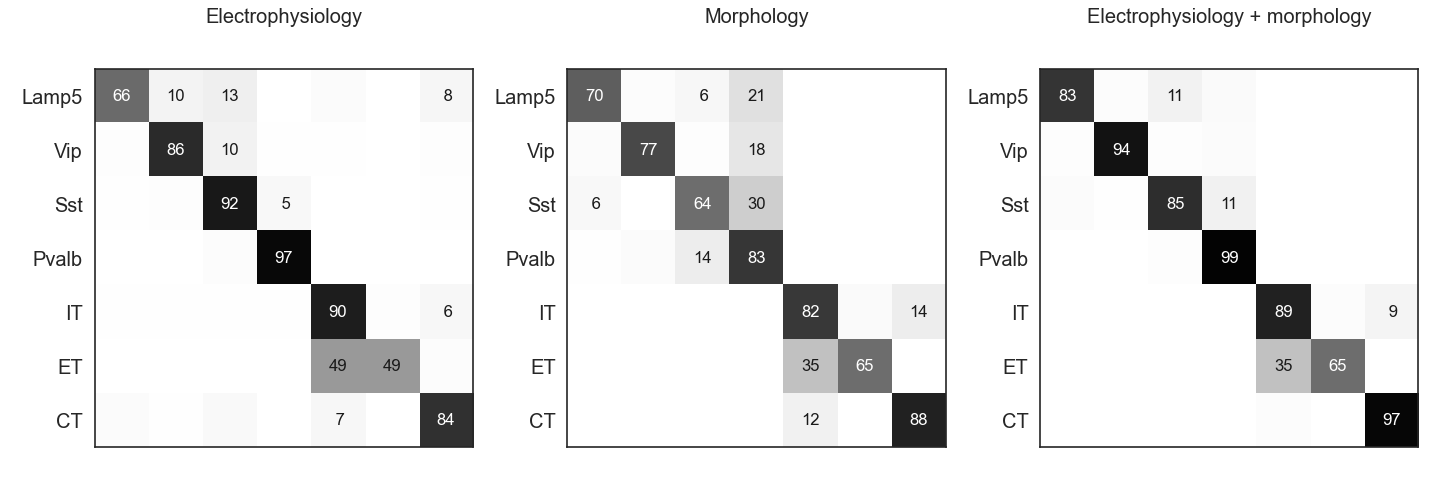

In [12]:
# plot the confusion matrices for kNN on ephys, morph, and ephys+morph features
plt.figure(figsize=(6, 2))
titles = {'e': 'Electrophysiology', 'm': 'Morphology', 'me': 'Electrophysiology + morphology'}

for modenum, mode in enumerate(['e', 'm', 'me'], 1):
    ax = plt.subplot(1,3,modenum)
    plot_family_confusion(ax, mode)
    plt.title(titles[mode], y=1.07)
                
plt.tight_layout()

## Type variability

All available features and `sklearn.NearestNeighbors()` are used for this 10-nearest neighbor clustring as well. This is also a confusion matrix for broad cell families, but instead of aggregating by the cell family labels, it aggregates by the smaller transcriptomic types.

In [13]:
def get_type_confusion(mode, k=10, cutoff=10, restrictLayers=False):
    """
    Create a confusion matrix between cell types and families. Row: cell types, columns: families.
    Precaution - this function depends on the global variables tsnedata, tsnes, ttypes, and clusterN. 
    For details on what they contain, take a look at the first part of the notebook.
    
    Attributes:
    mode: "e" for electrophysiological, "m" for morphometric, "me" for ephys+morpho
    k: the nearest neighbor parameter. Default is 10 nearest neighbors.
    cutoff: how many cells need to be assigned to each label for the confusion matrix to be calculated
    restrictLayers: True - only uses cells from the most common layer of that ttype, False - uses all layers of that ttype
    """

    X = tsnedata[mode][usedcells[mode]]  # the cells and features before it was transformed by t-SNE
    keepcells = usedcells[mode] # a filter to get the cells that have valid values for analysis

    classes = np.array(['Lamp5', 'Vip', 'Sst', 'Pvalb', 'IT', 'ET', 'CT'])
    classlabels = ttypes['family'][usedcells[mode]] # the family name labels corresponding to cells in X

    C = np.zeros((clusterN, classes.size)) * np.nan

    # distances: the Euclidean distances to the k nearest neighbors
    # indices: the indices (from X) of the k nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors()

    # for each cell type index t
    for t in range(clusterN):
        # this is a filter that gets the indices of the cell type t
        ind = (ttypes['m1consensus_ass'][keepcells].astype(int) == t) 

        # if restrictLayers is True, only keep the cells that came from the most common layer for cell type t
        if np.sum(ind) >= cutoff and restrictLayers:
            l, lc = np.unique(ourLayers[keepcells][ind], return_counts=True)
            mostCommonLayer = l[np.argmax(lc)]
            ind &= (ourLayers[keepcells] == mostCommonLayer)

        # only calculate the confusion matrix for cells that have at least 10 cells classified to that label
        if np.sum(ind) >= cutoff:
            C[t,:] = 0
            num = 0
            for i in np.where(ind)[0]:
                u, count = np.unique(classlabels[indices[i,:]], return_counts=True)
                if u[np.argmax(count)] in classes:
                    num += 1
                    C[t, classes==u[np.argmax(count)]] += 1
            C[t,:] /= num

    return C
        
        
def plot_type_confusion(ax, mode, ylabelfontsize=None, showylabels=True):
    """
    Creates the confusion matrix using get_type_confusion() and plots it.
    Precaution - this function depends on the global variables tsnedata, tsnes, ttypes, and clusterN. 
    For details on what they contain, take a look at the first part of the notebook.
    
    Arguments
    ax: the subplot index to plot in
    mode: "e" for electrophysiological, "m" for morphometric, "me" for ephys+morpho
    ylabelfontsize:　the font size for the cell family names on the left of the plot
    showylabels: True - prints the cell family labels, False - does not print the labels
    """
    # use only the most common layer for each ttype when morphometric features are involved
    C = get_type_confusion(mode, restrictLayers=(mode!='e')) 
    classes = np.array(['Lamp5', 'Vip', 'Sst', 'Pvalb', 'IT', 'ET', 'CT'])

    aboveCutoff = ~np.isnan(C[:,0]) # plot only where there are values in the confusion matrix
    
    # settings for the axes
    plt.sca(ax)
    plt.imshow(C[aboveCutoff,:].T, vmin=0, vmax=1, cmap=plt.get_cmap('Greys'), aspect='auto')
    plt.xticks(np.arange(np.sum(aboveCutoff))+.15, clusterNames[aboveCutoff], fontsize=5, rotation=90) # +.15 to adjust label positions
    plt.gca().tick_params(axis='both', length=0)
    if showylabels:
        plt.yticks(np.arange(classes.size), classes, fontsize=ylabelfontsize)
    else:
        plt.yticks([])
    plt.ylim([-.5, classes.size-.5])
    plt.xlim([-.5,np.sum(aboveCutoff)-.5])
    plt.gca().invert_yaxis()
    
    # plot arrows where the cells were misclassified over 25 of the time
    # this strange outer if statement is probably because all cell types but L6 IT_2 were
    # classified in correct families more than 75 of the time.
    for i,t in enumerate(np.where(aboveCutoff)[0]):
        if (np.max(C[t,:]) < .75) or (mode=='m' and clusterNames[t]=='L6 IT_2'):
            if t < 60: # for cell types under id 60, plot arrows pointing upwards
                plt.scatter(i,4,marker='^',c='k',s=5)
                plt.plot([i,i], [4,4.6], c='k', linewidth=.8)
            else:
                plt.scatter(i,2,marker='v',c='k',s=5)
                plt.plot([i,i], [2,1.4], c='k', linewidth=.8)

    return C

<IPython.core.display.Javascript object>


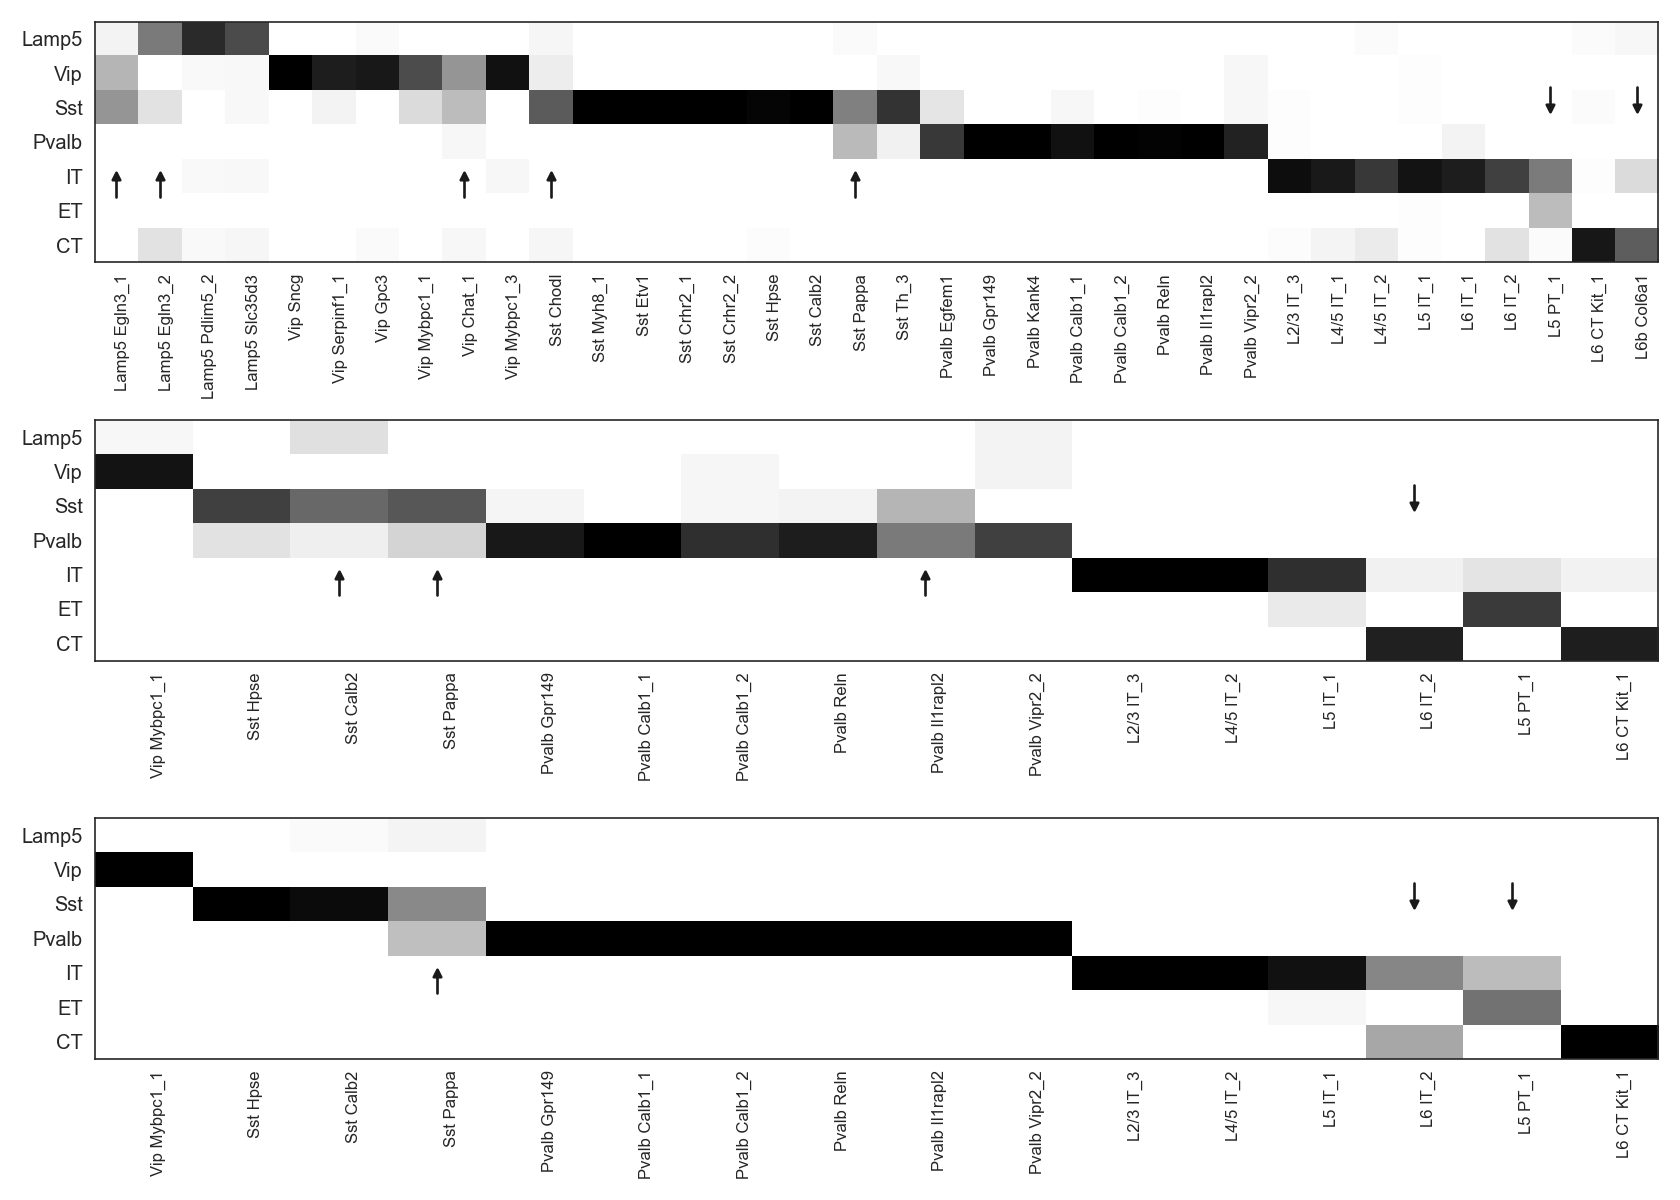

36
16
16


In [14]:
plt.figure(figsize=(7,5))
plt.subplot(311)
C = plot_type_confusion(plt.gca(), 'e')
print(np.sum(~np.isnan(C[:,0])))

plt.subplot(312)
C = plot_type_confusion(plt.gca(), 'm')
print(np.sum(~np.isnan(C[:,0])))

plt.subplot(313)
C = plot_type_confusion(plt.gca(), 'me')
print(np.sum(~np.isnan(C[:,0])))

plt.tight_layout()

### Ok, what's next?

The stuff I feel is missing is:

- This only shows the CM for the broad cell families. What about the smaller cell types? This article claims that the smaller cell types are more difficult to separate, so why don't they show it?
- Confusion matrices may not contain very much information for small datasets like this, so use adjusted mutual information and Fowlkes-Mallows score too
- Why does this article claim that the smaller cell types are hard to classify using transcriptomic+ephys+morph when they only use ephys and morph for kNN clustering? I should try results with transcriptomic+ephys+morph, transcriptomic+ephys, and transcriptomic+morph

The functions I will need:

1. 3 to get the confusion matrices - one for family-family, one for ttype-family, and one for ttype-ttype
2. One that gets AMI and FMS and prints them as evaluation results. Maybe I'll need 3 for this too, not sure
3. 3 to display the confusion matrices, one for each CM type
4. One that does kNN and evaluation in a single call

In [15]:
from kNN_evaluation import *

--------------------------Electrophysiology--------------------------
Adjusted Mutual Info: 0.4032092036756901
Fowlkes-Mallows Score: 0.29493067372917464 

--------------------------Morphology--------------------------
Adjusted Mutual Info: 0.4506037937182021
Fowlkes-Mallows Score: 0.3672213749659492 

--------------------------Electrophysiology + morphology--------------------------
Adjusted Mutual Info: 0.5526721564057856
Fowlkes-Mallows Score: 0.4790670032882983 



<IPython.core.display.Javascript object>


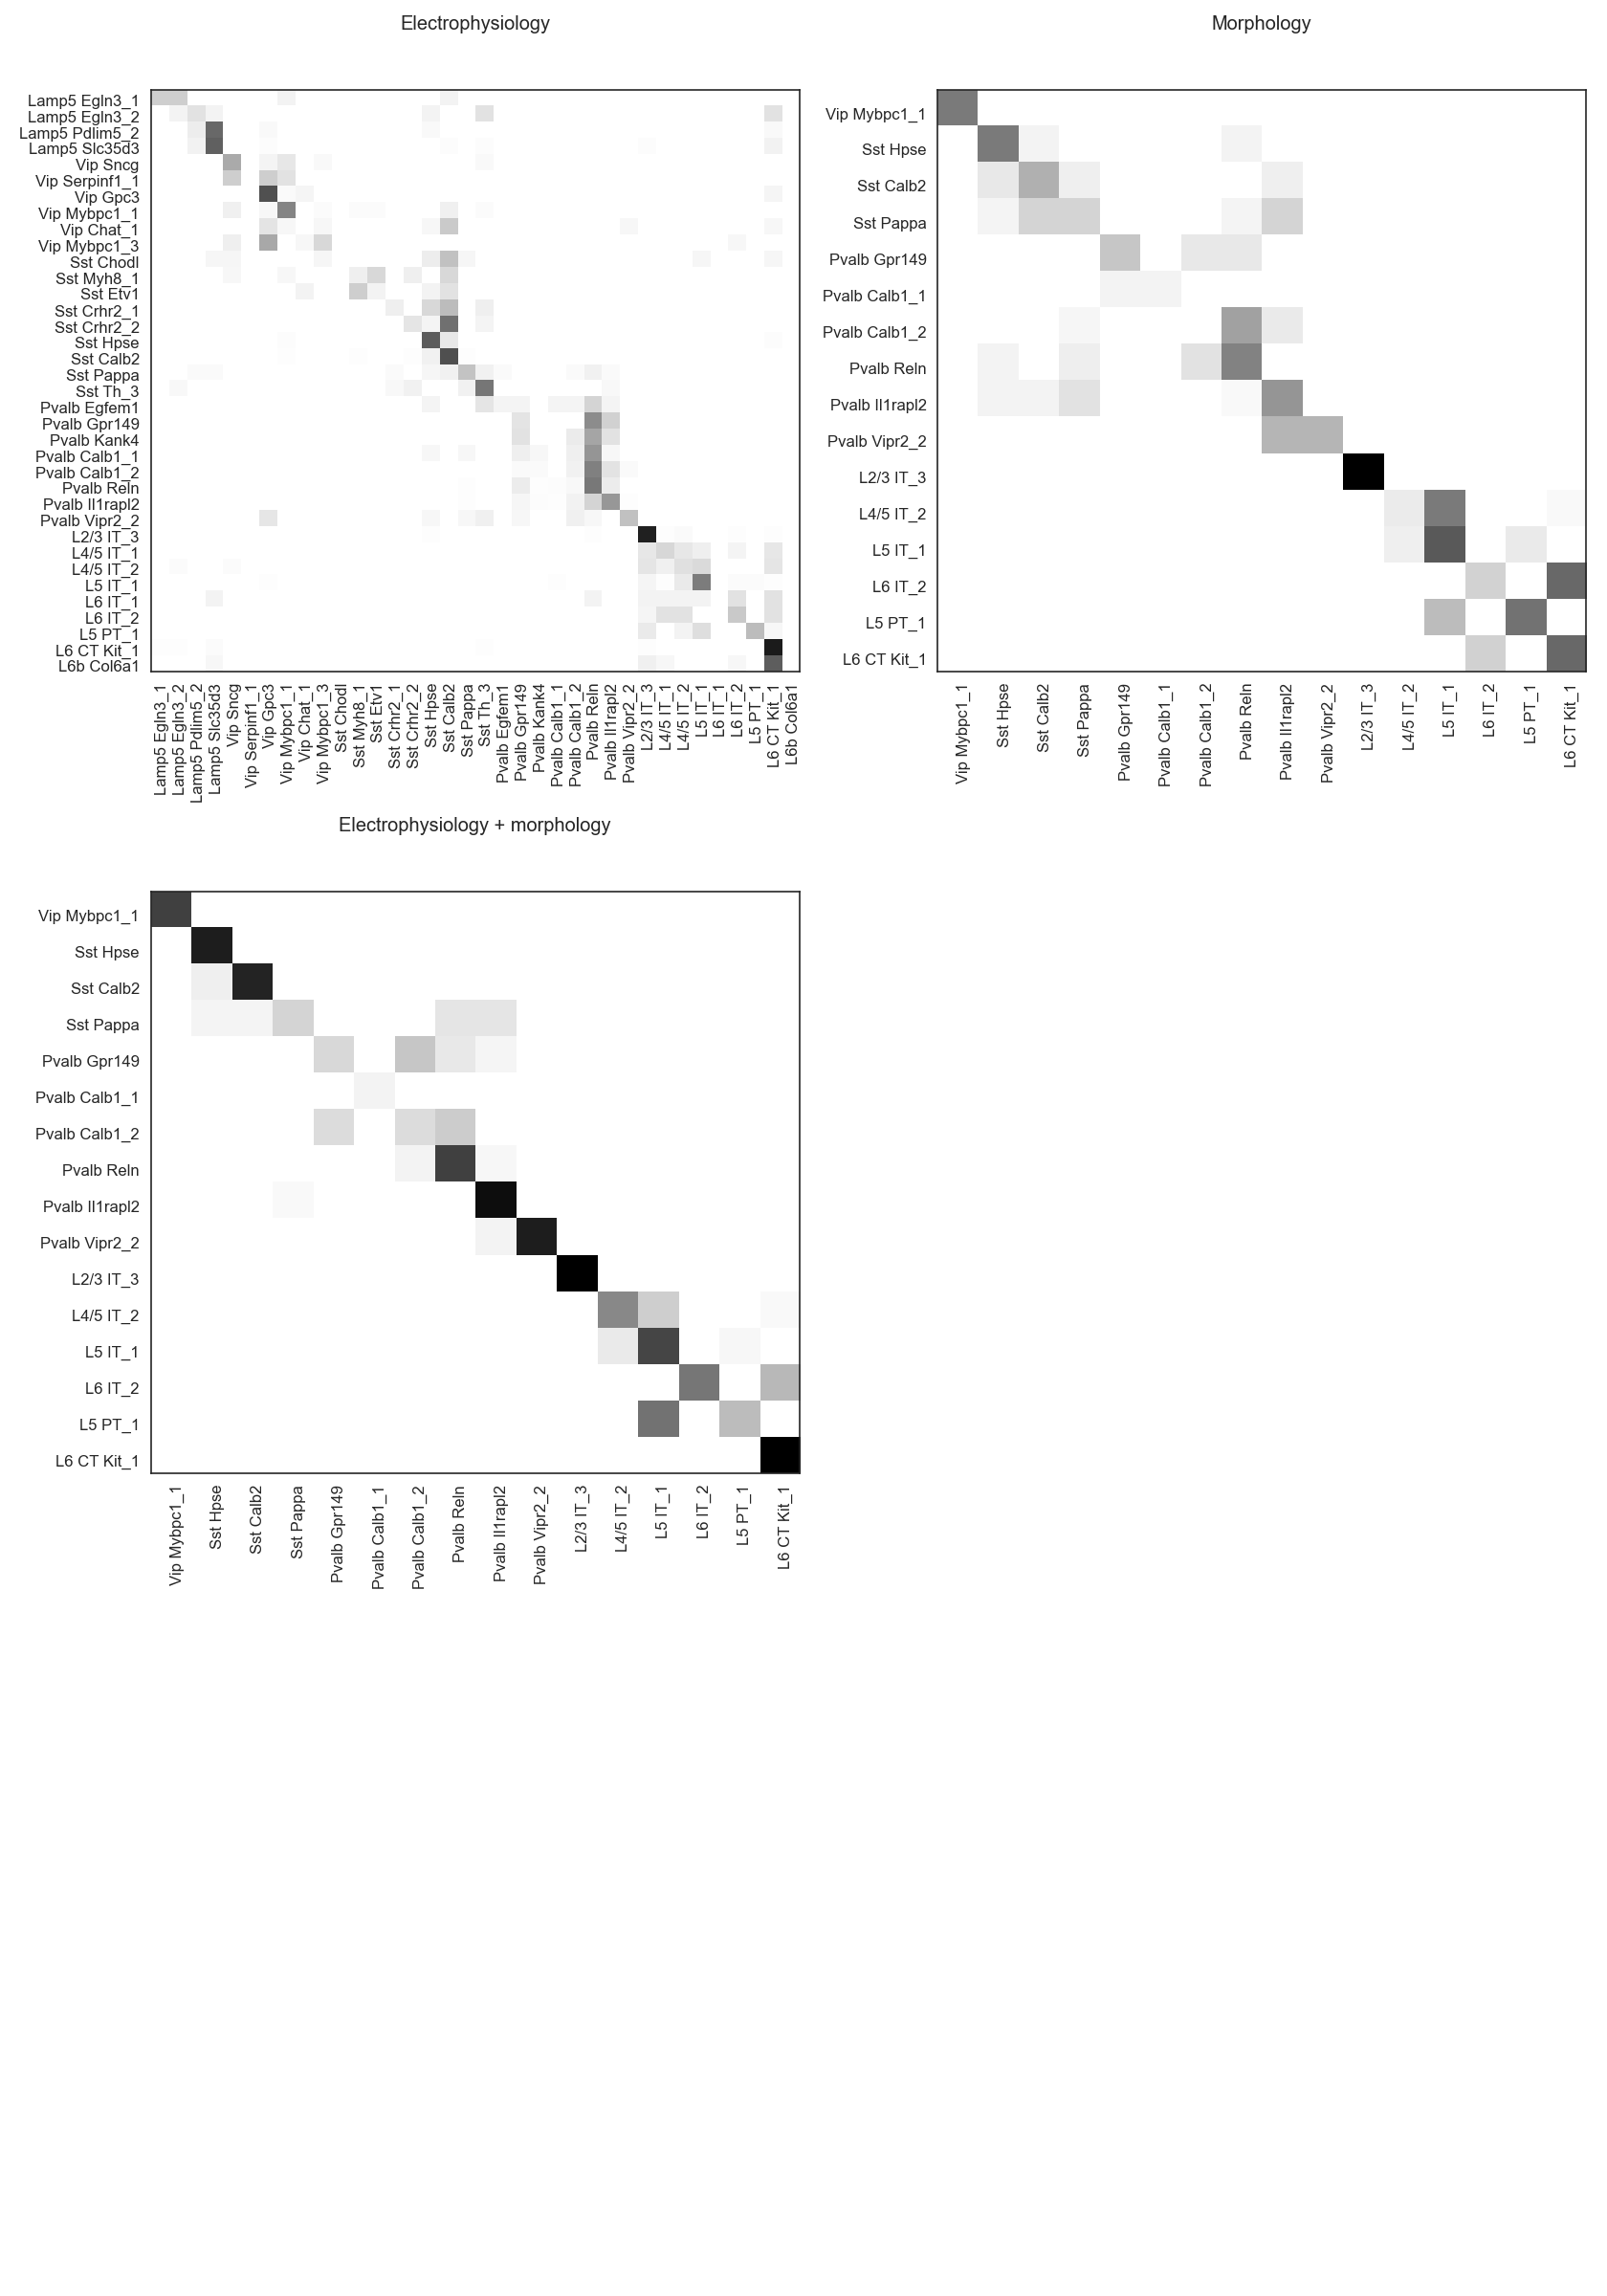

In [18]:
def kNN_alldata(dataset, cell_selectors, labelset, layerset, clusterNames, titles, matrix_type, k, cutoff=10,clusterN=88):
    """A function that gets kNN results for every feature set."""
    cm_dict = {}
    kNN_dict = {}
    label_dict = {}
    
    # perform unsupervised kNN clustering for all feature subsets
    # and get the confusion matrices 
    for mode, data in dataset.items():
        X = data[cell_selectors[mode]]
        restrictLayers = (mode!='e')
        
        if matrix_type=="ff" or matrix_type=="tf":
            labels = labelset["family"][cell_selectors[mode]]
        if matrix_type=="tt":
            labels = labelset['m1consensus_ass'][cell_selectors[mode]].astype(int)
        label_dict[mode] = labels
        
        nbrs = NearestNeighbors(n_neighbors=k).fit(X)
        _, indices = nbrs.kneighbors()
        kNN_dict[mode] = indices
        
        
        if matrix_type=="ff":
            classes = np.array(['Lamp5', 'Vip', 'Sst', 'Pvalb', 'IT', 'ET', 'CT'])
            cm_dict[mode] = kNN_confusion_matrix_ff(indices, labels, classes)
        if matrix_type=="tf":
            classes = np.array(['Lamp5', 'Vip', 'Sst', 'Pvalb', 'IT', 'ET', 'CT'])
            cm_dict[mode] = kNN_confusion_matrix_tf(indices, labels, classes, cell_selectors[mode], 
                                                labelset, layerset, restrictLayers=restrictLayers)
        if matrix_type=="tt":
            cm_dict[mode] = kNN_confusion_matrix_tt(indices, labels, cell_selectors[mode], layerset, restrictLayers=restrictLayers)
    
    #plot the confusion matrices
    if matrix_type=="ff":
        pred_dict, AMI_dict, FMS_dict = evaluate_ami_fms(kNN_dict, label_dict, titles, class_list=classes)
        kNN_plot_cm_ff(cm_dict, classes, titles, figsize=(6,4))
    if matrix_type=="tf":
        pred_dict, AMI_dict, FMS_dict = evaluate_ami_fms(kNN_dict, label_dict, titles, class_list=classes)
        kNN_plot_cm_tf(cm_dict, classes, titles, clusterNames, figsize=(7,10))
    if matrix_type=="tt":
        pred_dict, AMI_dict, FMS_dict = evaluate_ami_fms(kNN_dict, label_dict, titles, class_list=clusterN)
        kNN_plot_cm_tt(cm_dict, titles, clusterNames, figsize=(7,10))
    return pred_dict, label_dict, cm_dict, AMI_dict, FMS_dict
      
titles = {'e': 'Electrophysiology', 'm': 'Morphology', 'me': 'Electrophysiology + morphology'}
p,l,c, ami, fms = kNN_alldata(tsnedata, usedcells, ttypes, ourLayers, clusterNames, titles, matrix_type="tt", k=10)